In [7]:
import yaml

In [8]:
# load menu
with open("menu.yml", 'r') as f:
    menu = yaml.safe_load(f)

In [9]:
if menu['toolbox']:
    import os
    import glob
    import math
    import geopandas as gpd
    import pandas as pd
    import numpy as np
    import pint
    import folium
    from pathlib import Path
    import matplotlib.pyplot as plt
    import rasterio
    from rasterio.warp import calculate_default_transform, reproject, Resampling
    from rasterio.plot import show
    from rasterstats import zonal_stats
    from osgeo import gdal, gdalconst
    from scipy.ndimage import generic_filter
    from shapely.geometry import LineString
    from shapely.ops import linemerge, unary_union
    import fiona
    import osmnx as ox
    from shapely.geometry import LineString, mapping
    from skimage import measure
    from shapely.ops import unary_union

read AOI shapefile


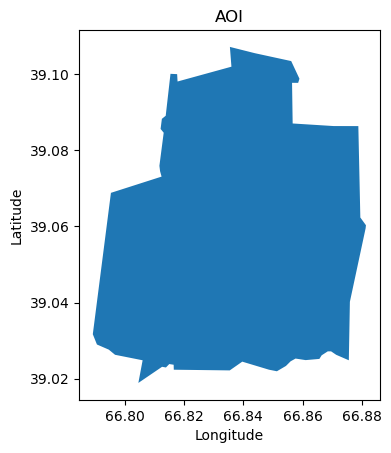

shahrisabz
uzbekistan


In [14]:
# SET UP ##############################################

# load city inputs files, to be updated for each city scan
with open("city_inputs.yml", 'r') as f:
    city_inputs = yaml.safe_load(f)

city = city_inputs['city_name'].replace(' ', '_').lower()
country = city_inputs['country_name'].replace(' ', '_').lower()
# load global inputs, such as data sources that generally remain the same across scans

with open("global_inputs.yml", 'r') as f:
    global_inputs = yaml.safe_load(f)

# Read AOI shapefile --------
print('read AOI shapefile')
# transform the input shp to correct prj (epsg 4326)
aoi_file = gpd.read_file(city_inputs['AOI_path']).to_crs(epsg = 4326)
features = aoi_file.geometry

# Define output folder ---------
output_folder = Path('output')
plot_folder = Path(output_folder/'plots')
pickle_folder = Path(output_folder/'pickles')

if not os.path.exists(output_folder):
    os.mkdir(output_folder)
    
fig, ax = plt.subplots()
features.plot(ax=ax)
plt.title('AOI')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
print(city)
print(country)

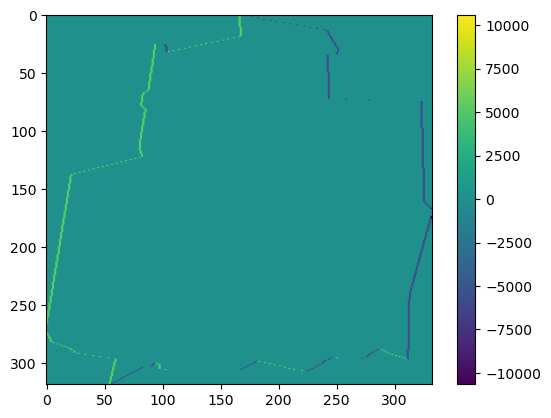

Slope calculation completed and saved to: output/shahrisabz_slope.tif


In [11]:
#Slope
def get_slope():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)
    
    if menu['elevation']:  
        elev_path = os.path.join(output_folder, city + '_elevation.tif')
        with rasterio.open(elev_path) as src:
            elev_data = src.read(1)  

            # Calculate the slope
            slope = np.gradient(elev_data)[1]

            
            plt.imshow(slope, cmap='viridis')
            plt.colorbar()
            plt.show()

            
            slope_path = os.path.join(output_folder, city + "_slope.tif")

            
            transform, width, height = calculate_default_transform(
                src.crs, 'EPSG:4326', src.width, src.height, *src.bounds)

            
            profile = src.profile
            profile.update({
                'crs': 'EPSG:4326',
                'transform': transform,
                'width': width,
                'height': height
            })

            
            with rasterio.open(slope_path, 'w', **profile) as dst:
                # Reproject the slope data
                reproject(
                    source=rasterio.band(src, 1),
                    destination=rasterio.band(dst, 1),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs='EPSG:4326',
                    resampling=Resampling.nearest)
                
                # Write the slope data to the output file
                dst.write(slope, 1)

            print("Slope calculation completed and saved to:", slope_path)

get_slope()

In [12]:
#Get contours
def get_contours(output_folder, city):
    try:
        with open("global_inputs.yml", 'r') as f:
            global_inputs = yaml.safe_load(f)

        if global_inputs.get('menu', {}).get('elevation', False):  
            elev_path = os.path.join(output_folder, city + '_elevation.tif')
            with rasterio.open(elev_path) as src:
                elev_data = src.read(1)  

            # Determine contour intervals based on elevation data
            contour_intervals = determine_contour_intervals(elev_data)

            # Generate contours using numpy gradient
            contours = []
            for interval in contour_intervals:
                # Find contour lines for the current interval
                contour_lines = find_contours(elev_data, interval, src.transform)
                contours.extend(contour_lines)

            # Merge contour lines into MultiLineString
            contour_multilines = unary_union(contours)
            # Save contour lines as shapefile
            contour_path = os.path.join(output_folder, f"{city}_contours.shp")
            save_contours_shapefile(contour_multilines, contour_path)
            print("Contours generated successfully.")
    except Exception as e:
        print("Exception:", e)

def find_contours(elev_data, interval, transform):
    # Find contour lines
    contours = measure.find_contours(elev_data, interval)

    # Convert contour lines to LineString
    contour_lines = []
    for contour in contours:
        line = []
        for point in contour:
            y, x = point
            lon, lat = transform * (x, y)  # Transform pixel coordinates to CRS
            line.append((lon, lat))
        contour_lines.append(LineString(line))

    return contour_lines

def determine_contour_intervals(elev_data):
    # Determine contour intervals based on elevation data
    min_elev = np.nanmin(elev_data)
    max_elev = np.nanmax(elev_data)
    
    # Define the number of contour intervals desired
    num_intervals = 5000  # You can adjust this based on your preference
    #minimum of intervals - why do i need num_interval? 10m minimum 
    
    # Calculate contour intervals based on quantiles
    contour_intervals = np.linspace(min_elev, max_elev, num_intervals + 1)
    
    return contour_intervals

def save_contours_shapefile(contour_multilines, output_path):
    schema = {'geometry': 'LineString', 'properties': {}}
    with fiona.open(output_path, 'w', 'ESRI Shapefile', schema) as output:
        for line in contour_multilines.geoms:
            output.write({'geometry': mapping(line), 'properties': {}})

# Example usage:
get_contours(output_folder, city)

In [ ]:
#Zonal Stats for Fathom data
#PU WSF
def get_pu_wsf():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)
    
    if menu['flood']:  
        pu_path = os.path.join(output_folder, city + '_pu.tif')
        with rasterio.open(elev_path) as src:
            pu_data = src.read(1)  


In [ ]:
#PU Population

In [ ]:
#PU Amenities

In [ ]:
#FU WSF

In [ ]:
#FU Population

In [ ]:
#FU Amenities

In [ ]:
#Comb WSF

In [ ]:
#Comb Population

In [ ]:
#Comb Amenities

In [ ]:
#Coastal Flooding